## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään.

#### Datankäsittely

In [1]:
import os
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100)
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(150,150),
    shuffle=True
)
   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


In [2]:
from keras import Sequential
from keras import layers
from keras import regularizers

model = Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Rescaling(scale=1./255),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       135,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,204 (606.27 KB)

 Trainable params: 155,012 (605.52 KB)

 Non-trainable params: 192 (768.00 B)

In [3]:
import keras

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [4]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5458 - loss: 7.2278 - val_accuracy: 0.2500 - val_loss: 2.8841
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9821 - loss: 0.3257 - val_accuracy: 0.2500 - val_loss: 3.2597
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9727 - loss: 0.3936 - val_accuracy: 0.4000 - val_loss: 3.2074
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9969 - loss: 0.0700 - val_accuracy: 0.5750 - val_loss: 1.9164
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9592 - loss: 0.3365 - val_accuracy: 0.8500 - val_loss: 0.8198
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9933 - loss: 0.1200 - val_accuracy: 0.4750 - val_loss: 6.9308
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9695 - loss: 0.1864 - val_accuracy: 0.5250 - val_loss: 9.9312
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9714 - loss: 0.6952 - val_accuracy: 0

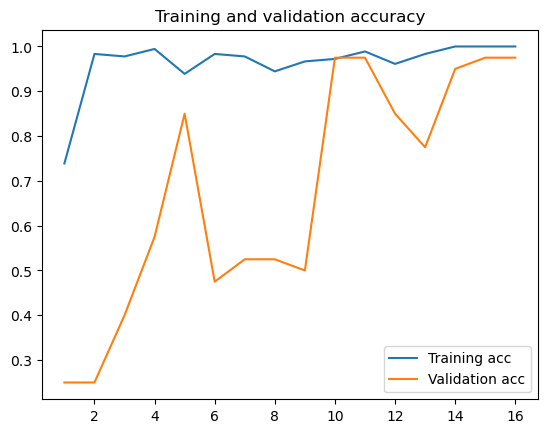

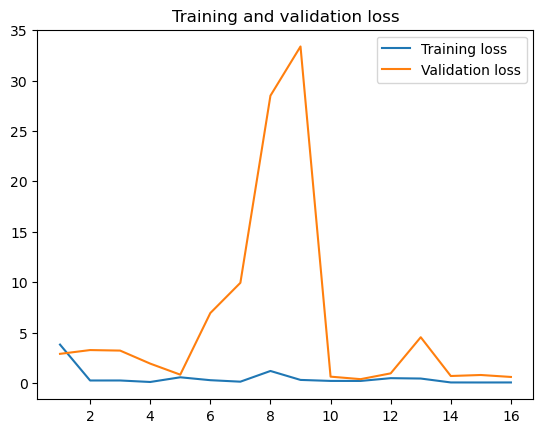

In [5]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.72
Test accuracy: 0.95
